##### This notebook contains ΑRΙΜΑ.
ARIMA, short for 'Auto Regressive Integrated Moving Average' is actually a class of models that 'explains' a given time series based on its own past values, that is, its own lags and the lagged forecast errors, so that equation can be used to forecast future values. 

#### TIme Series Forecasting
Time series forecasting occurs when you make scientific predictions based on historical time stamped data. It involves building models through historical analysis and using them to make observations and drive future strategic decision-making.

##### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot  as plt
import seaborn as sns
import math
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller

from sklearn import metrics

##### Dataset Loading

In [2]:
dataset = pd.read_csv("Data/BTC-USD.csv")
print(dataset.shape)
dataset.head()

(1827, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-12-21,800.643982,834.281006,799.405029,834.281006,834.281006,155576000
1,2016-12-22,834.179993,875.781982,834.148987,864.539978,864.539978,200027008
2,2016-12-23,864.888000,925.117004,864.677002,921.984009,921.984009,275564000
3,2016-12-24,922.179993,923.479004,886.335022,898.822021,898.822021,137727008
4,2016-12-25,899.651978,899.651978,862.424011,896.182983,896.182983,143664992


In [3]:
dataset["Date"]=pd.to_datetime(dataset['Date'])
dataset['Year'] = dataset['Date'].dt.year
dataset

,Date,Open,High,Low,Close,Adj Close,Volume,Year
0,2016-12-21,800.643982,834.281006,799.405029,834.281006,834.281006,155576000,2016
1,2016-12-22,834.179993,875.781982,834.148987,864.539978,864.539978,200027008,2016
2,2016-12-23,864.888000,925.117004,864.677002,921.984009,921.984009,275564000,2016
3,2016-12-24,922.179993,923.479004,886.335022,898.822021,898.822021,137727008,2016
4,2016-12-25,899.651978,899.651978,862.424011,896.182983,896.182983,143664992,2016
...,...,...,...,...,...,...,...,...
1822,2021-12-17,47653.730469,48004.894531,45618.214844,46202.144531,46202.144531,32902725329,2021
1823,2021-12-18,46219.253906,47313.828125,45598.441406,46848.777344,46848.777344,26098292690,2021
1824,2021-12-19,46853.867188,48089.664063,46502.953125,46707.015625,46707.015625,25154053861,2021
1825,2021-12-20,46707.062500,47401.718750,45579.808594,46880.277344,46880.277344,30961902129,2021


We only need the Closing values.

In [4]:
ts = dataset['Close'].copy()

<AxesSubplot:>

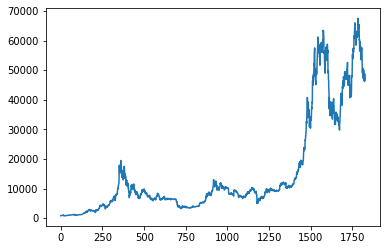

In [5]:
ts.plot()

According to https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7 in order to create ARIMA, our dataset should be stationary. According to the previous plot, our dataset is non stationary so we are going to use some techniqs to make it stationary. We are going to use the Null Hypothesis. </br>
According to it,only if p value > 0.05: Null Hypothesis is accepted. </br>
H0: the data is not stationary.

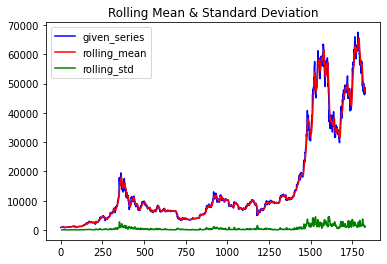

Results of Dickey-Fuller Test:
Test Statistic                   -0.602678
p-value                           0.870376
#Lags Used                       24.000000
Number of Observations Used    1802.000000
Critical Value (1%)              -3.433984
Critical Value (5%)              -2.863145
Critical Value (10%)             -2.567625
dtype: float64


In [6]:
def test_for_stationary(input_data):
    r_mean = input_data.rolling(window = 7,center=False).mean()
    r_std = input_data.rolling(window = 7,center=False).std()
    
    # plotting the data
    given = plt.plot(input_data, color = 'blue', label = 'given_series')
    rolling_mean = plt.plot(r_mean, color = 'red', label = 'rolling_mean')
    rolling_std = plt.plot(r_std, color ='green', label = 'rolling_std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
     #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(input_data)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
      
test_for_stationary(ts)

According to the results, p-value > 0.05, so H0 is accepted and our dataset is not stationary. </br>
The next step is to use log.

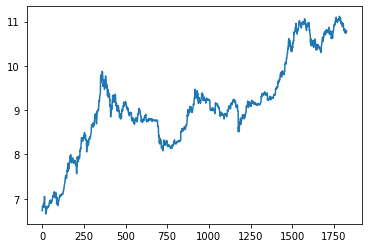

In [7]:
ts_log = np.log(ts)
plt.plot(ts_log)

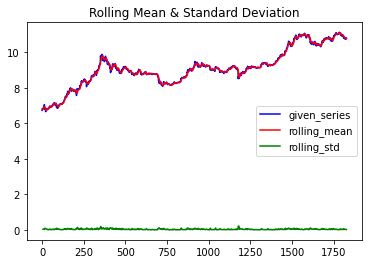

Results of Dickey-Fuller Test:
Test Statistic                   -1.489247
p-value                           0.538824
#Lags Used                        2.000000
Number of Observations Used    1824.000000
Critical Value (1%)              -3.433940
Critical Value (5%)              -2.863126
Critical Value (10%)             -2.567614
dtype: float64


In [8]:
test_for_stationary(ts_log)

According to the results, still p-value > 0.05, so H0 is accepted and our dataset is not stationary. </br>
So we have to remove trend and seasonality with differencing.

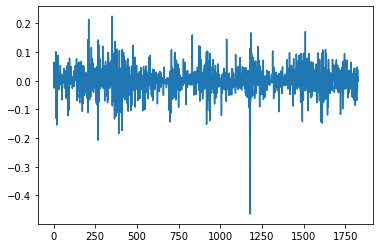

In [9]:
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

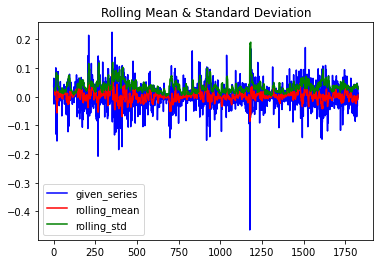

Results of Dickey-Fuller Test:
Test Statistic                  -29.709082
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1824.000000
Critical Value (1%)              -3.433940
Critical Value (5%)              -2.863126
Critical Value (10%)             -2.567614
dtype: float64


In [10]:
ts_log_diff.dropna(inplace=True)
test_for_stationary(ts_log_diff)

As our time series is now stationary asour p value is less than 0.05 therefore we can apply time series forecasting models.

In [11]:
ts_log_diff.describe()

count    1826.000000
mean        0.002226
std         0.042281
min        -0.464730
25%        -0.015421
50%         0.002415
75%         0.021709
max         0.225119
Name: Close, dtype: float64

### Split Data

In [12]:
to_row = int(len(ts_log_diff)*0.9)
training_data = list(ts_log_diff[0:to_row])
testing_data = list(ts_log_diff[to_row:])

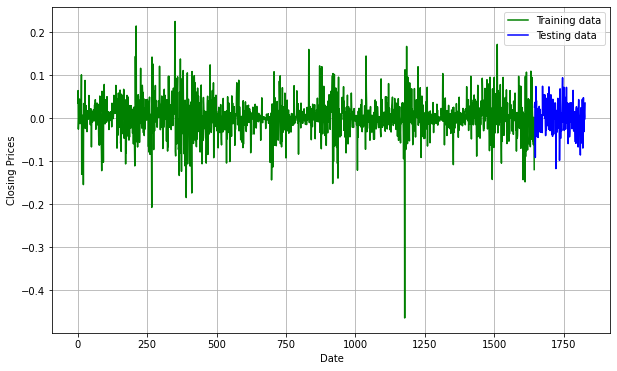

In [13]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Closing Prices")
plt.plot(ts_log_diff[0:to_row],'green',label="Training data")
plt.plot(ts_log_diff[to_row:],'blue',label="Testing data")
plt.legend()

We are now ready to create our ARIMA Model!

### ARIMA Model Creation

In [16]:
model_predictions=[]
error_list=[]
n_test_observ = len(testing_data)

The first model we are about to create has p=4,d=1 and q=1.

In [17]:
for i in range (n_test_observ):
    model = ARIMA(training_data, order = (4, 1, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    actual_test_value = testing_data[i]
    training_data.append(actual_test_value)
    
    # Calculating the error
    error = ((abs(yhat - actual_test_value)) / actual_test_value) * 100
    
    error_list.append(error)
    print('predicted = %f,   expected = %f,   error = %f ' % (yhat, actual_test_value, error), '%')
    
    
    
# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean Error in Predicting  : %f ' % (sum(error_list)/float(len(error_list))), '%')

predicted = 0.005454,   expected = 0.025833,   error = 78.886660  %
predicted = -0.004972,   expected = 0.036767,   error = 113.523022  %
predicted = 0.001276,   expected = 0.027476,   error = 95.356541  %
predicted = 0.001793,   expected = -0.091305,   error = -101.963982  %
predicted = 0.005794,   expected = 0.017188,   error = 66.288108  %
predicted = -0.002935,   expected = 0.073747,   error = 103.980364  %
predicted = -0.000102,   expected = -0.006233,   error = -98.365743  %
predicted = 0.004212,   expected = 0.040785,   error = 89.673523  %
predicted = 0.000197,   expected = -0.023325,   error = -100.846457  %
predicted = 0.004776,   expected = -0.042818,   error = -111.155075  %
predicted = 0.002181,   expected = 0.009632,   error = 77.357653  %
predicted = -0.000338,   expected = 0.022505,   error = 101.501370  %
predicted = 0.001136,   expected = 0.017704,   error = 93.580988  %
predicted = 0.001662,   expected = -0.044675,   error = -103.720183  %
predicted = 0.003990,   exp

In [18]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1825
Model:                 ARIMA(4, 1, 1)   Log Likelihood                3179.902
Date:                Sun, 09 Jan 2022   AIC                          -6347.804
Time:                        22:10:09   BIC                          -6314.751
Sample:                             0   HQIC                         -6335.611
                               - 1825                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0345      0.017     -2.039      0.041      -0.068      -0.001
ar.L2          0.0330      0.020      1.617      0.106      -0.007       0.073
ar.L3         -0.0026      0.021     -0.124      0.9

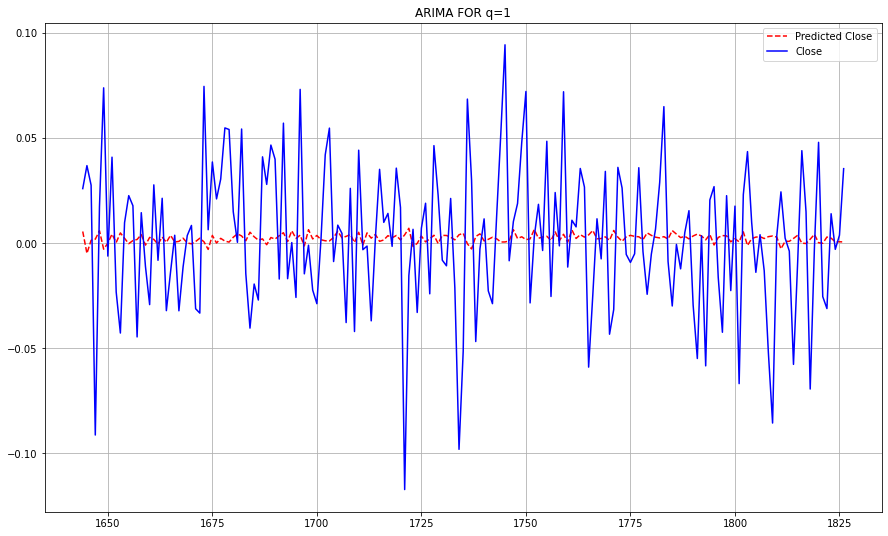

In [19]:
plt.figure(figsize=(15,9))
plt.grid(True)

data_range = ts_log_diff[to_row:].index

plt.title ('ARIMA FOR q=1')
#plt.plot(ts_log_diff)
plt.plot(data_range,model_predictions,color = 'red', linestyle = 'dashed',label='Predicted Close')
plt.plot(data_range,testing_data,color = 'blue',label='Close')
plt.legend(['Predicted Close','Close'])

In [20]:
predict_q1 = model_fit.predict()
predict_q1

array([0.        , 0.03562726, 0.04899914, ..., 0.00122588, 0.00045706,
       0.00147757])

In [21]:
mse1 = mean_squared_error(testing_data, model_predictions)
mse1

0.0012333017127601172

The second model we are about to create has p=4,d=1 and q=2.

In [22]:
model_predictions=[]
len(model_predictions)

0

It's very important for our models to be trained in the same amount of training data. So we have to reassigned our training data as we did for the first model.

In [23]:
training_data = list(ts_log_diff[0:to_row])

In [24]:
for i in range (n_test_observ):
    model = ARIMA(training_data,order=(4,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    actual_test_value = testing_data[i]
    training_data.append(actual_test_value)
    
    # Calculating the error
    error = ((abs(yhat - actual_test_value)) / actual_test_value) * 100
    
    error_list.append(error)
    print('predicted = %f,   expected = %f,   error = %f ' % (yhat, actual_test_value, error), '%')
    
    
    
# After iterating over whole test set the overall mean error is calculated.   
print('\n Mean Error in Predicting  : %f ' % (sum(error_list)/float(len(error_list))), '%')

predicted = 0.003436,   expected = 0.025833,   error = 86.698483  %
predicted = -0.002289,   expected = 0.036767,   error = 106.225052  %
predicted = -0.000437,   expected = 0.027476,   error = 101.592152  %
predicted = 0.002162,   expected = -0.091305,   error = -102.368164  %
predicted = 0.006291,   expected = 0.017188,   error = 63.401409  %
predicted = -0.003019,   expected = 0.073747,   error = 104.093261  %
predicted = -0.000061,   expected = -0.006233,   error = -99.021879  %
predicted = 0.003496,   expected = 0.040785,   error = 91.427274  %
predicted = 0.001405,   expected = -0.023325,   error = -106.024722  %
predicted = 0.004053,   expected = -0.042818,   error = -109.465356  %
predicted = 0.002439,   expected = 0.009632,   error = 74.676444  %
predicted = 0.000312,   expected = 0.022505,   error = 98.614769  %
predicted = 0.000653,   expected = 0.017704,   error = 96.310861  %
predicted = 0.002055,   expected = -0.044675,   error = -104.600219  %
predicted = 0.004079,   exp

In [25]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1825
Model:                 ARIMA(4, 1, 2)   Log Likelihood                3180.456
Date:                Sun, 09 Jan 2022   AIC                          -6346.912
Time:                        22:14:42   BIC                          -6308.350
Sample:                             0   HQIC                         -6332.687
                               - 1825                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9022      0.203     -4.449      0.000      -1.300      -0.505
ar.L2          0.0023      0.026      0.091      0.927      -0.048       0.052
ar.L3          0.0248      0.027      0.917      0.3

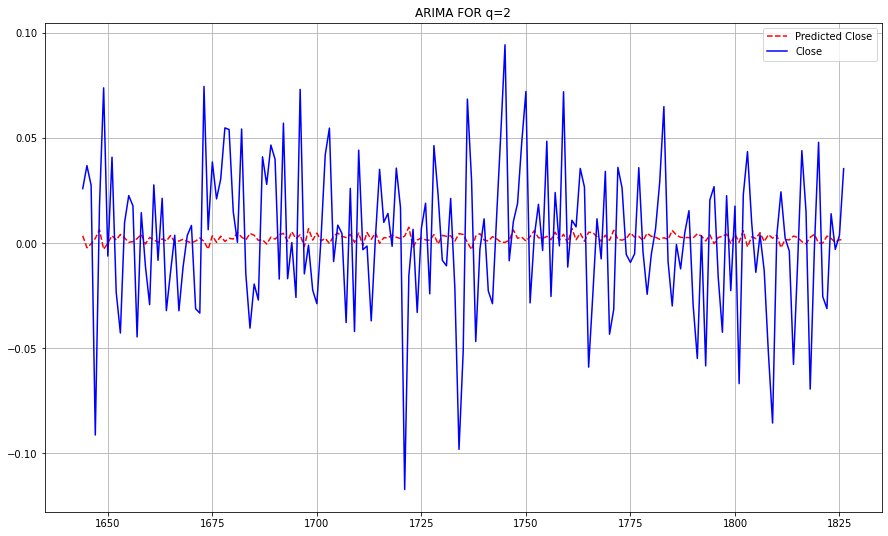

In [29]:
plt.figure(figsize=(15,9))
plt.grid(True)
plt.title ('ARIMA FOR q=2')
           
data_range = ts_log_diff[to_row:].index

plt.plot(data_range,model_predictions,color = 'red', linestyle = 'dashed',label='Predicted Close')
plt.plot(data_range,testing_data,color = 'blue',label='Close')


plt.legend()
plt.show()

In [31]:
predict_q2 = model_fit.predict()
predict_q2

array([0.        , 0.03562726, 0.04908237, ..., 0.00214805, 0.00030923,
       0.0015861 ])

In [32]:
mse2 = mean_squared_error(testing_data, model_predictions)
mse2

0.001234001919725285

### Comparing our Models

##### Predicted Values

In [33]:
compDf = pd.DataFrame({'ARIMA (4,1,1)': predict_q1, 'ARIMA (4,1,2)': predict_q2})
compDf

,"ARIMA (4,1,1)","ARIMA (4,1,2)"
0,0.000000,0.000000
1,0.035627,0.035627
2,0.048999,0.049082
3,0.028747,0.028429
4,0.017337,0.017433
...,...,...
1820,0.000085,-0.000094
1821,0.002784,0.003167
1822,0.001226,0.002148
1823,0.000457,0.000309


##### Mean Squared Error

In [34]:
msErrors = pd.DataFrame({'ARIMA (4,1,1)': mse1, 'ARIMA (4,1,2)': mse2},index=[0])
msErrors

,"ARIMA (4,1,1)","ARIMA (4,1,2)"
0,0.001233,0.001234
